**Стилизация изображений с помощью нейронных сетей**

Евгений Борисов esborisov@sevsu.ru

---

A Neural Algorithm of Artistic Style   
Leon A. Gatys, Alexander S. Ecker, Matthias Bethge   
2015  

https://arxiv.org/pdf/1508.06576v2.pdf

"Стилизация изображений с помощью нейронных сетей: никакой мистики, просто матан"

https://itnan.ru/post.php?c=1&p=306916

https://github.com/utkarshvermaa/Image-Style-Transfer

---

## библиотеки

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import torch
import torch.optim as optim

from torchvision import transforms
from torchvision import models

In [3]:
torch.__version__

'1.8.1+cu102'

## загружаем предобученную модель свёрточной сети

In [4]:
# будем использовать только часть модели (features) 
vgg = models.vgg19(pretrained=True).features

# фиксируем параметры модели, её обучать не будем
for param in vgg.parameters():  param.requires_grad_(False)

In [5]:
# инициализируем GPU  (если он есть)
# device = torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg = vgg.to(device)

---

In [6]:
# загружаем картинку
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = max_size if (max(image.size) > max_size) else max(image.size)
    size = shape if (shape is not None) else size
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # удаляем прозрачность (alpha channel)
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [7]:
def plot_imgs(d,col = 5,fw=12,ih=3):
    files = os.listdir(d)
    rows  = np.ceil(len(files)/col).astype(int)
    fig = plt.figure(figsize=(fw,ih*rows))
    for i,f in enumerate(files):
        plt.subplot(rows,col,i+1)
        plt.axis(False)
        # plt.title(f)
        plt.title(str(i))
        plt.imshow( Image.open(os.path.join(d,f)).convert('RGB') )
    fig.tight_layout()    
    return files

---

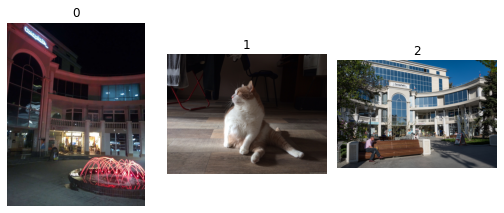

In [8]:
# картинки для стилизации
d_content = '../data/img-styling/content'
files_content = plot_imgs(d_content)

In [9]:
n_file_content = 1
content = load_image( os.path.join(d_content,files_content[n_file_content]) ).to(device)

---

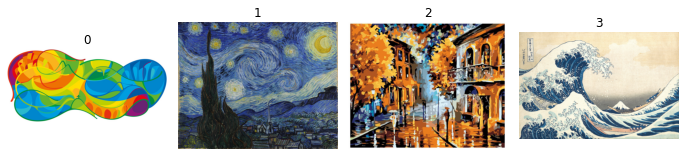

In [10]:
# образцы стилей 
d_style = '../data/img-styling/style'
files_style = plot_imgs(d_style)

In [11]:
n_file_style = 1
style = load_image( os.path.join(d_style,files_style[n_file_style]), shape=content.shape[-2:]).to(device)

---

In [12]:
# обратное преобразование тензора в картинку
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

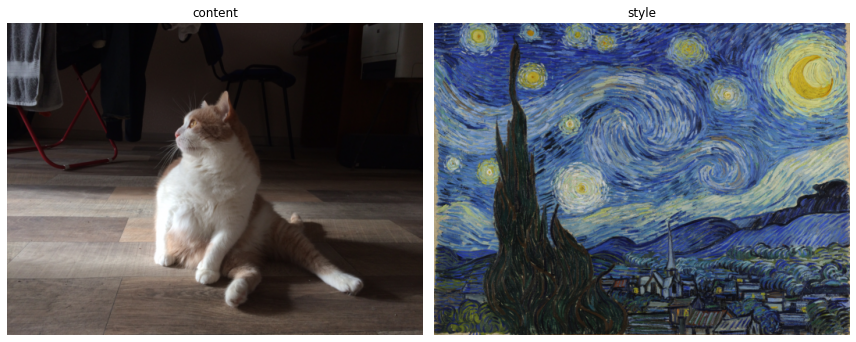

In [13]:
# рисуем выбранные исходники

fig = plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
plt.axis(False)
plt.title('content')
plt.imshow(im_convert(content))

plt.subplot(1,2,2)
plt.axis(False)
plt.title('style')
plt.imshow(im_convert(style))

fig.tight_layout()
plt.show()

---

In [14]:
# структура модели 
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [15]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {
             '0': 'conv1_1',
             '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '28': 'conv5_1',
            '21': 'conv4_2',
        }
        
        
    ## -- do not need to change the code below this line -- ##
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [16]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    ## get the batch_size, depth, height, and width of the Tensor
    batch_size, d, h, w = tensor.size()
    
    ## reshape it, so we're multiplying the features for each channel
    tensor = tensor.view(tensor.shape[1], -1)
    
    ## calculate the gram matrix
    gram = torch.mm(tensor, torch.t(tensor))
    
    return gram 

In [17]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [18]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

In [21]:
!mkdir result

mkdir: невозможно создать каталог «result»: Файл существует


200 loss: 20931326.000000


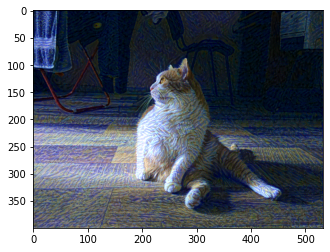

400 loss: 6614752.500000


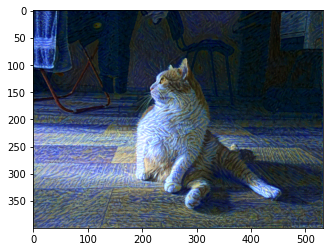

600 loss: 3390971.000000


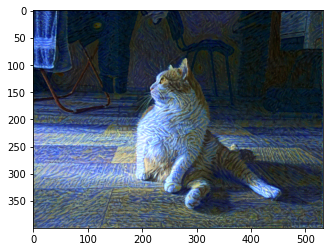

800 loss: 2136323.250000


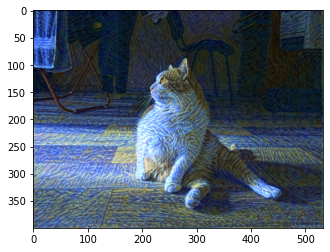

1000 loss: 1500218.000000


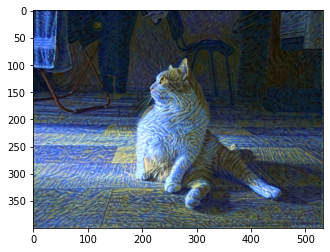

CPU times: user 56.5 s, sys: 37.8 s, total: 1min 34s
Wall time: 1min 34s


In [22]:
%%time 

steps = 1000  # decide how many iterations to update your image (5000)

# for displaying the target image, intermittently
show_every = 200

# iteration hyperparameters
# optimizer = optim.Adam([target], lr=.001)
optimizer = optim.Adam([target], lr=.008)

# будем уменьшать скорость обучения в процессе
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=.7)

for ii in range(1, steps+1):
    
    ## TODO: get the features from your target image    
    ## Then calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        ## TODO: Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        ## TODO:  get the "style" style representation
        style_gram = style_grams[layer]
        ## TODO: Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    ## TODO:  calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    ## -- do not need to change code, below -- ##
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        scheduler.step()
        print('%i loss: %f'%(ii,total_loss.item()))
        plt.imshow(im_convert(target))
        plt.show()

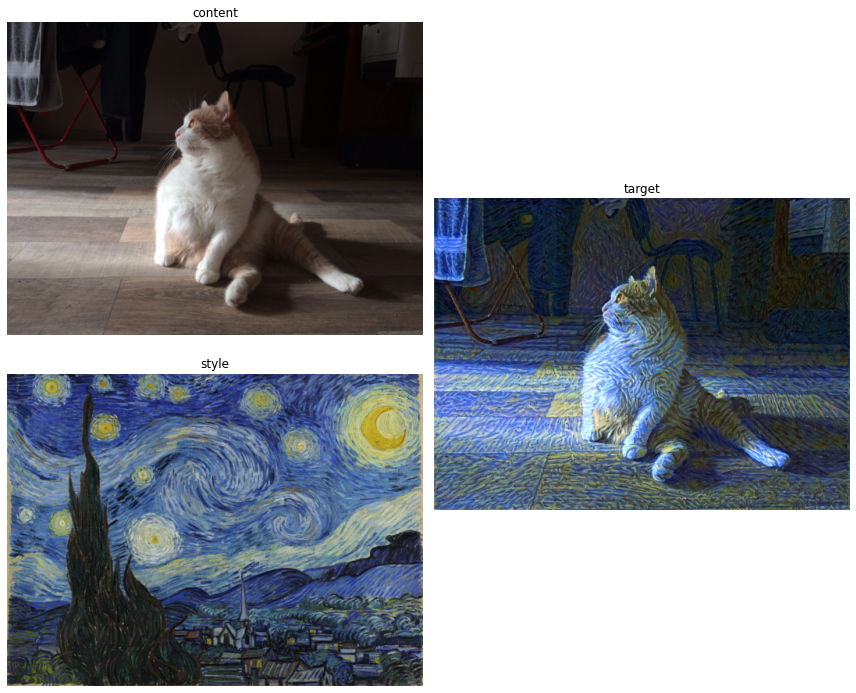

In [23]:
import os

fig = plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.axis(False)
plt.title('content')
plt.imshow(im_convert(content))

plt.subplot(2,2,3)
plt.axis(False)
plt.title('style')
plt.imshow(im_convert(style))

plt.subplot(1,2,2)
plt.axis(False)
plt.title('target')
plt.imshow(im_convert(target))

fig.tight_layout()


plt.savefig(
    'result/[%i]_%s+%s'%(
        steps,
        files_style[n_file_style],
        files_content[n_file_content]
    )
)
